In [23]:
## Import necessary libraries
# rioxarray extends xarray to understand geospatial rasters (GeoTIFF, NetCDF…)
import numpy as np
import rasterio
from rasterio.transform import from_origin
import rioxarray as rxr
# from rasterio.enums import Resampling
import rasterio
# import rasterio.plot
import netCDF4 as nc
import numpy as np
import geojson as gj
import pandas as pd
import geopandas as gpd
from affine import Affine
import matplotlib.pyplot as plt
# from shapely.geometry import Point
from matplotlib.ticker import FormatStrFormatter
import datetime
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


2025-09-16 11:22:45


## Loading the GeoTiff data

In [24]:

# Importing Geotiff file with rioxarray to get metadata 
'''
Loading MWIR/Imager data from (e.g:) F002_L1__IR__L2L1M0__2025-08-12T212259.010953Z_2025-08-13T111644.731945Z_e81989f5_MWIR.tif

F002 - Mission 
L1 - Level 1 processing
IR - Infrared
L2L1M0 - Level 2 processing, Level 1 data, Mode 0
2025-01-10T215412.018348Z - Start time of data acquisition
2025-04-10T154832.806087Z - End time of data acquisition
97706189 - Unique identifier for the data file
MWIR - Mid-Wave Infrared band

'''

### Analogus to fits files stored in a directory loading the GeoTiFF file

da = rxr.open_rasterio("Dataset_2/F002_L1__IR__L2L1M0__2025-08-12T212259.010953Z_2025-08-13T111644.731945Z_e81989f5_MWIR.tif").squeeze() # Remove the band dimension if it's single-band
print("Original coordinate reference system:", da.rio.crs) # Coordinate Reference System
print("Original resolution:", da.rio.resolution()) # (pixel width, pixel height)
print("Original bounds:", da.rio.bounds()) # (left, bottom, right, top) in the CRS units
print("Original shape:", da.shape) # (height, width)
print("xarray attrs:", da.attrs)  # sometimes holds units/long_name

print()

Original coordinate reference system: EPSG:3857
Original resolution: (305.748113140704, -305.748113140704)
Original bounds: (-11584184.51067506, 3287403.712488916, -11036283.891926918, 4226661.916057158)
Original shape: (3072, 1792)
xarray attrs: {'OVR_RESAMPLING_ALG': 'NEAREST', 'TILING_SCHEME_NAME': 'WebMercatorQuad', 'TILING_SCHEME_ZOOM_LEVEL': 9, 'AREA_OR_POINT': 'Area', 'STATISTICS_MAXIMUM': 4.304077709197998, 'STATISTICS_MEAN': 2.9532063, 'STATISTICS_MINIMUM': 1.5453663349151612, 'STATISTICS_STDDEV': 0.8292124, '_FillValue': np.float32(65555.0), 'scale_factor': 1.0, 'add_offset': 0.0}



In [4]:
# Importing Geotiff file with rasterio to get metadata 
path = "Dataset_2/F002_L1__IR__L2L1M0__2025-08-12T212259.010953Z_2025-08-13T111644.731945Z_e81989f5_MWIR.tif"

with rasterio.open(path) as ds:
    print("CRS:", ds.crs)
    print("Resolution:", ds.res)
    print("Bounds:", ds.bounds)
    print("Dtypes:", ds.dtypes)                 # per-band dtype
    print("Nodata:", ds.nodatavals)             # per-band NoData
    print("Descriptions:", ds.descriptions)     # per-band descriptions (names)
    print("Global tags:", ds.tags())            # file-level tags/metadata
    print("Band-1 tags:", ds.tags(1))           # band-level tags (often where units live)
    print("Scales:", ds.scales)                 # scale_factor (if any)
    print("Offsets:", ds.offsets)               # add_offset (if any)
    print("Profile:", ds.profile)               # compact summary


with rasterio.open(path) as ds:
    print("Number of bands:", ds.count)        # how many channels
    print("Descriptions:", ds.descriptions)    # names/labels of each band
    for i in range(1, ds.count + 1):
        print(f"Band {i} dtype:", ds.dtypes[i-1])
        print(f"Band {i} tags:", ds.tags(i))   # metadata per band

CRS: EPSG:3857
Resolution: (305.748113140704, 305.748113140704)
Bounds: BoundingBox(left=-11584184.51067506, bottom=3287403.712488916, right=-11036283.891926918, top=4226661.916057158)
Dtypes: ('float32',)
Nodata: (65555.0,)
Descriptions: (None,)
Global tags: {'OVR_RESAMPLING_ALG': 'NEAREST', 'TILING_SCHEME_NAME': 'WebMercatorQuad', 'TILING_SCHEME_ZOOM_LEVEL': '9', 'AREA_OR_POINT': 'Area'}
Band-1 tags: {'STATISTICS_MAXIMUM': '4.304077709197998', 'STATISTICS_MEAN': '2.9532063', 'STATISTICS_MINIMUM': '1.5453663349151612', 'STATISTICS_STDDEV': '0.8292124'}
Scales: (1.0,)
Offsets: (0.0,)
Profile: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 65555.0, 'width': 1792, 'height': 3072, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["E

Data range before masking: 1.256406307220459 to 65555.0


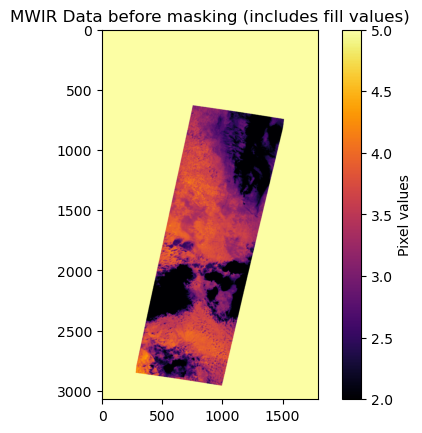

In [27]:
# This shows all pixel values, including invalid NoData fill values (huge negatives).
arr_pre_mask = da.values

lo, hi = np.nanpercentile(arr_pre_mask, 1), np.nanpercentile(arr_pre_mask, 80)

print(f"Data range before masking: {lo} to {hi}")
plt.imshow(da.values, cmap="inferno",vmin=2, vmax=5) # Units are W/m^2/sr/um for radiance
plt.colorbar(label="Pixel values")
plt.title("MWIR Data before masking (includes fill values)")

plt.savefig("Plots/Dataset_2/MWIR_Data_before_masking.png", dpi=300)

In [28]:
## As the mask value is already applied to the data set at -3.4e38 we can use this to mask out the invalid values

# Mask out NoData and non-finite values
da_clean = da.where(np.isfinite(da) & (da != da.rio.nodata))

# Optional: mask negative radiance (physically invalid)
da_clean = da_clean.where(da_clean >= 0)

arr = da_clean.values
print("Shape:", arr.shape)
print("Min:", np.nanmin(arr))
print("P02:", np.nanpercentile(arr, 2))
print("Median:", np.nanmedian(arr))
print("P98:", np.nanpercentile(arr, 98))
print("Max:", np.nanmax(arr))
print("NaN fraction:", np.mean(~np.isfinite(arr)))
print("Units:", da.attrs.get("units"))




Shape: (3072, 1792)
Min: 0.95322645
P02: 1.1915742
Median: 3.218596
P98: 3.9746375
Max: 6.2132306
NaN fraction: 0.6909150623139881
Units: None


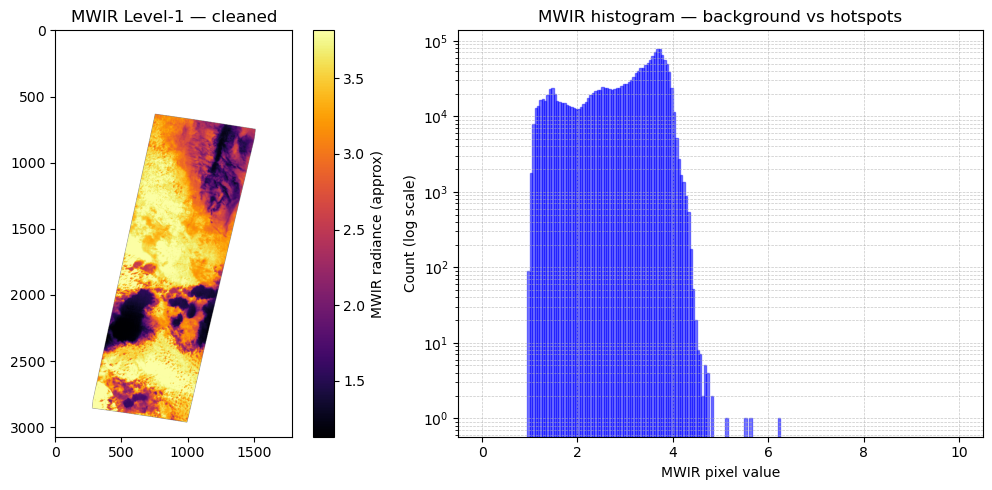

In [31]:


# Percentile stretch for background detail
lo, hi = np.nanpercentile(arr, 1), np.nanpercentile(arr, 90)

# Create side-by-side figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot 1: MWIR image (robust stretch) ---
im = axes[0].imshow(arr, vmin=lo, vmax=hi, cmap="inferno")
cbar = plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)
cbar.set_label("MWIR radiance (approx)", fontsize=10)

axes[0].set_title("MWIR Level-1 — cleaned", fontsize=12, loc="center")
axes[0].axis("on")  # cleaner without axes

# --- Plot 2: Histogram ---
vals = arr[np.isfinite(arr)]
axes[1].hist(vals, bins=200, log=True, range=(0, 10), color="Blue", edgecolor="blue",alpha = 0.5)
axes[1].set_xlabel("MWIR pixel value", fontsize=10)
axes[1].set_ylabel("Count (log scale)", fontsize=10)
axes[1].set_title("MWIR histogram — background vs hotspots", fontsize=12, loc="center")
axes[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)


# Tidy layout
plt.tight_layout()
plt.savefig("Plots/Dataset_2/MWIR_combined.png", dpi=300,bbox_inches='tight')
plt.show()


In [8]:
print(np.where(np.nanmax(arr) == arr)) # Find the location of the maximum value in the array

(array([1788]), array([829]))


## Load the geojson data

In [32]:
import geopandas as gpd
import numpy as np
from affine import Affine

# --- Load detections ---
# Read in GeoJSON file containing detection points (e.g., potential hotspots).
gdf = gpd.read_file(
    "Dataset_2/F002_L1__IR__L2L1M0__2025-08-12T212259.010953Z_2025-08-13T111644.731945Z_e81989f5_model_detections.geojson"
)

# --- Reproject to EPSG:4326 for lon/lat inspection ---
# EPSG:4326 = WGS84 (longitude/latitude in degrees).
# Useful for quick checks and plotting on standard maps.
gdf_ll = gdf.to_crs("EPSG:4326")
gdf_ll["lon"] = gdf_ll.geometry.x
gdf_ll["lat"] = gdf_ll.geometry.y

print(gdf_ll[["lon", "lat"]].head())

# --- Match raster CRS for pixel mapping ---
# Reproject detections to the raster's CRS (e.g., EPSG:3857).
# This ensures coordinates align with raster pixels.
gdf = gdf_ll.to_crs(da.rio.crs)

# --- Get raster affine transform ---
# da.rio.transform() returns an Affine object describing how to map
# between raster grid coordinates (row, col) and spatial coordinates (x, y).
# It has the form:
#   x = A*col + B*row + C
#   y = D*col + E*row + F
A = da.rio.transform()
A = Affine(*A[:6]) if not isinstance(A, Affine) else A

# Invert the transform: now we can map (x,y) → (col,row).
# This is what we need to find the pixel each detection falls into.

Ainv = ~A

# Print few world coordinates
print("Geometric x and y values = ", gdf.geometry.x.values[:5], gdf.geometry.y.values[:5])

# --- Convert detection coordinates to pixel indices ---
# Apply inverse affine transform to get fractional (col, row) positions.
cols, rows = Ainv * (gdf.geometry.x.values, gdf.geometry.y.values)
print("Sample cols, rows:", cols[:5], rows[:5])

# Round to nearest integer pixel indices.
# NOTE: rows = y-direction (height), cols = x-direction (width).
cols = np.round(cols).astype(int)
rows = np.round(rows).astype(int)

# --- Clip to valid raster bounds ---
H, W = arr.shape
ok = (rows >= 0) & (rows < H) & (cols >= 0) & (cols < W)

# Assign row/col values; invalid indices → -1.
gdf["row"] = np.where(ok, rows, -1)
gdf["col"] = np.where(ok, cols, -1)

# Extract raster values (e.g., MWIR brightness temperature) at those pixel locations.
# Invalid indices get NaN instead.
gdf["back_ir"] = np.where(ok, arr[rows[ok], cols[ok]], np.nan)

print()
print(gdf[["row", "col", "back_ir"]].head())
print("Detections with valid MWIR:", gdf["back_ir"].notna().sum(), "/", len(gdf))
print()

# --- Merge lon/lat back into GeoDataFrame ---
# Attach the EPSG:4326 lon/lat so both geographic and raster-based info are stored together.
gdf["lon"] = gdf_ll["lon"].values
gdf["lat"] = gdf_ll["lat"].values

print(gdf[["lon", "lat", "row", "col", "back_ir"]].head())


          lon        lat
0 -102.054135  31.797161
1 -102.052073  31.796773
2 -101.783227  31.359599
3 -101.782770  31.361360
4 -101.781175  31.359207
Geometric x and y values =  [-11360614.341548   -11360384.80075798 -11330457.00093617
 -11330406.12792888 -11330228.57334107] [3736714.20790564 3736663.38908432 3679538.5057776  3679768.07754841
 3679487.40350407]
Sample cols, rows: [731.22338133 731.97413262 829.85797404 830.02436267 830.60508444] [1602.45537779 1602.62158919 1789.45801058 1788.70715796 1789.62514906]

    row  col   back_ir
0  1602  731  3.457036
1  1603  732  3.390665
2  1789  830  5.131003
3  1789  830  5.131003
4  1790  831  4.132938
Detections with valid MWIR: 21 / 21

          lon        lat   row  col   back_ir
0 -102.054135  31.797161  1602  731  3.457036
1 -102.052073  31.796773  1603  732  3.390665
2 -101.783227  31.359599  1789  830  5.131003
3 -101.782770  31.361360  1789  830  5.131003
4 -101.781175  31.359207  1790  831  4.132938


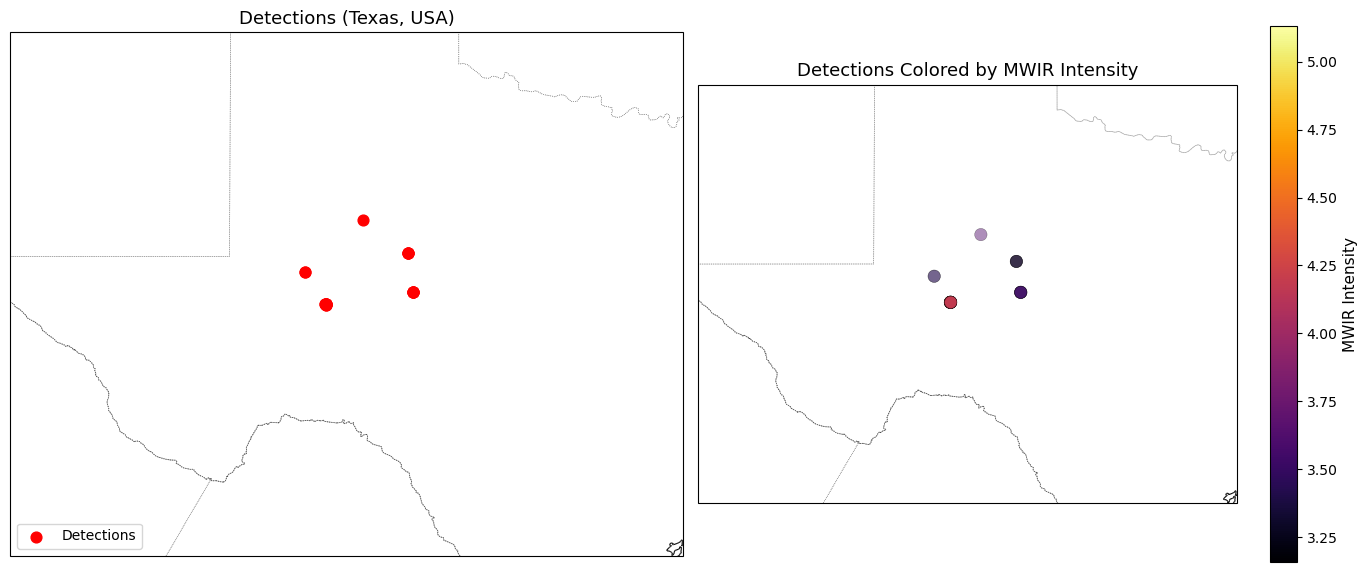

In [37]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --------------------------------------------------------
# Extract lon, lat, and MWIR values from GeoDataFrame
# --------------------------------------------------------
lons = gdf["lon"].values
lats = gdf["lat"].values
back_ir_vals = gdf["back_ir"].values

# Normalize MWIR values for per-point transparency (alpha)
norm = (back_ir_vals - back_ir_vals.min()) / (back_ir_vals.max() - back_ir_vals.min())
alphas = 0.3 + 0.7 * norm   # min alpha=0.3, max alpha=1.0

# --------------------------------------------------------
# Create a 1x2 subplot layout (side-by-side maps)
# --------------------------------------------------------
fig, axes = plt.subplots(
    1, 2, figsize=(14, 7),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Common map extent for Texas region
extent = [-106, -97, 28, 35]

# --------------------------------------------------------
# LEFT PANEL: Simple map with red scatter points
# --------------------------------------------------------
axes[0].coastlines(resolution="10m", linewidth=0.8)
axes[0].add_feature(cfeature.BORDERS, linestyle=":", edgecolor="black", linewidth=0.6)
axes[0].add_feature(cfeature.STATES, linestyle=":", edgecolor="gray", linewidth=0.5)

axes[0].scatter(
    lons, lats, 
    color="red", s=60,
    transform=ccrs.PlateCarree(),
    label="Detections"
)

axes[0].set_extent(extent, crs=ccrs.PlateCarree())
axes[0].set_title("Detections (Texas, USA)", fontsize=13)
axes[0].legend(loc="lower left", frameon=True)

# --------------------------------------------------------
# RIGHT PANEL: MWIR intensity scatter with color mapping
# --------------------------------------------------------
axes[1].coastlines(resolution="10m", linewidth=0.8)
axes[1].add_feature(cfeature.BORDERS, linestyle=":", edgecolor="black", linewidth=0.6)
axes[1].add_feature(cfeature.STATES, linestyle=":", edgecolor="gray", linewidth=0.5)

sc = axes[1].scatter(
    lons, lats,
    c=back_ir_vals,
    cmap="inferno",
    s=80,
    alpha=alphas,
    edgecolor="black", linewidth=0.3,
    transform=ccrs.PlateCarree()
)

axes[1].set_extent(extent, crs=ccrs.PlateCarree())
axes[1].set_title("Detections Colored by MWIR Intensity", fontsize=13)

# --------------------------------------------------------
# Shared colorbar for right panel
# --------------------------------------------------------
cbar = fig.colorbar(sc, ax=axes[1], orientation="vertical", shrink=0.8, pad=0.05)
cbar.set_label("MWIR Intensity", fontsize=11)

# --------------------------------------------------------
# Final layout
# --------------------------------------------------------
plt.tight_layout()
plt.savefig("Plots/Dataset_2/Coordinates_vs_MWIR.png", dpi=300, bbox_inches="tight")

plt.show()


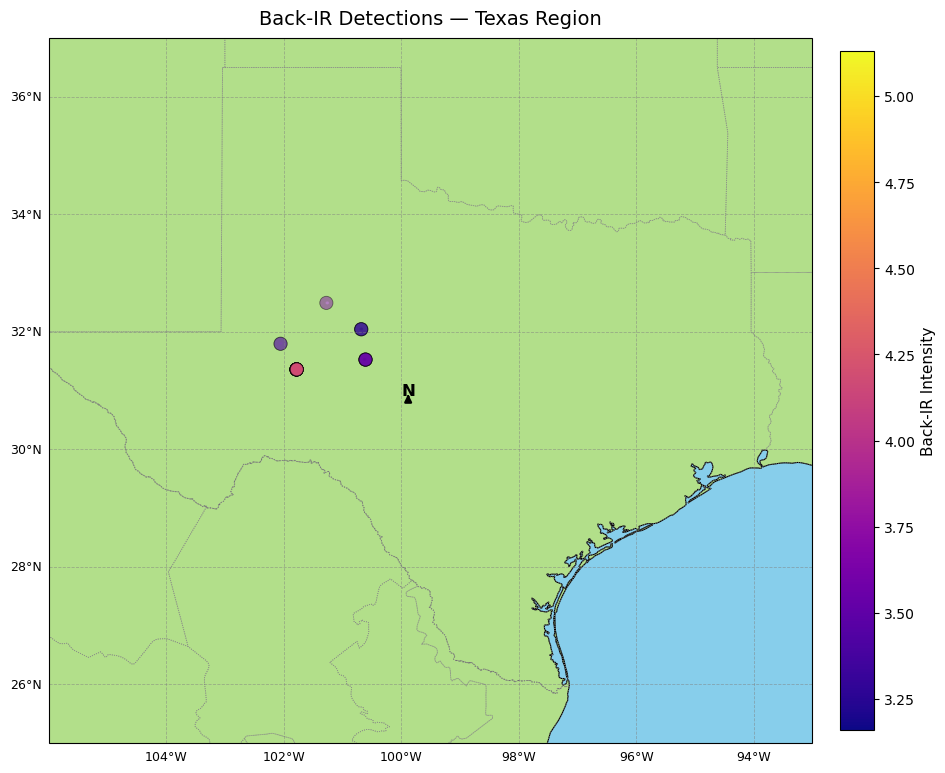

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# --- Extract lon/lat/IR from your GeoDataFrame ---
lons = gdf["lon"].values
lats = gdf["lat"].values
ir_vals = gdf["back_ir"].values   # rename for clarity

# --- Compute padded extent ---
pad = 1.0
lon_min, lon_max = lons.min() - pad, lons.max() + pad
lat_min, lat_max = lats.min() - pad, lats.max() + pad

# --- Alpha scaling ---
vmin, vmax = np.nanmin(ir_vals), np.nanmax(ir_vals)
if vmin == vmax:
    alphas = np.full_like(ir_vals, 0.7, dtype=float)
else:
    norm = (ir_vals - vmin) / (vmax - vmin + 1e-12)
    alphas = 0.3 + 0.7 * norm

# --- Figure setup ---
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# ====== Basemap styling ======
ax.add_feature(cfeature.LAND, facecolor="#b2df8a")   # soft green
ax.add_feature(cfeature.OCEAN, facecolor="#87CEEB")  # sky blue
ax.coastlines(resolution="10m", linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.7, edgecolor="#666666")
ax.add_feature(cfeature.STATES, linestyle=":", edgecolor="#888888", linewidth=0.6)

# ====== Optional density underlay ======
hb = ax.hexbin(
    lons, lats,
    gridsize=40, bins="log", mincnt=1,
    transform=ccrs.PlateCarree(),
    cmap="Greys", alpha=0.5
)

# ====== Scatter detections ======
sc = ax.scatter(
    lons, lats,
    c=ir_vals, cmap="plasma",
    s=90, edgecolors="k", linewidths=0.6,
    alpha=alphas,
    transform=ccrs.PlateCarree()
)

# Colorbar
cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.7, pad=0.03)
cbar.set_label("Back-IR Intensity", fontsize=11)

# ====== Gridlines ======
gl = ax.gridlines(draw_labels=True, linewidth=0.6, color="gray", alpha=0.55, linestyle="--")
gl.top_labels, gl.right_labels = False, False
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.xlocator, gl.ylocator = mticker.MultipleLocator(2), mticker.MultipleLocator(2)
gl.xlabel_style, gl.ylabel_style = {"size": 9}, {"size": 9}

# ====== Extent ======
ax.set_extent([-106, -93, 25, 37], crs=ccrs.PlateCarree())  # Texas bounding box

# ====== North arrow ======
nx = lon_min + 0.92 * (lon_max - lon_min)
ny = lat_min + 0.15 * (lat_max - lat_min)
ax.text(nx, ny + 0.055 * (lat_max - lat_min), "N", transform=ccrs.PlateCarree(),
        ha="center", va="center", fontsize=12, fontweight="bold")
ax.annotate("",
            xy=(nx, ny + 0.05 * (lat_max - lat_min)),
            xytext=(nx, ny),
            xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
            textcoords=ccrs.PlateCarree()._as_mpl_transform(ax),
            arrowprops=dict(arrowstyle="-|>", lw=1.8, color="k"))

# ====== Title ======
ax.set_title("Back-IR Detections — Texas Region", fontsize=14, pad=10)

plt.tight_layout()
plt.savefig("Plots/Dataset_2/Texas.png", dpi=300, bbox_inches="tight")

plt.show()


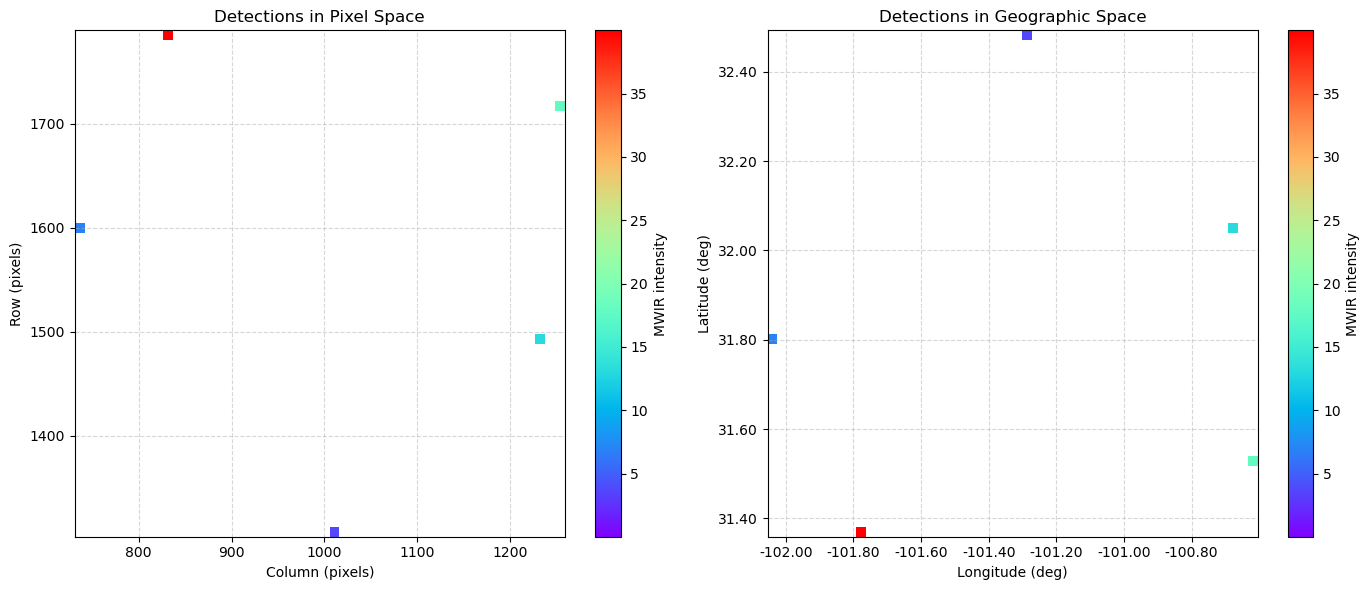

In [13]:


gdf_sub = gdf.copy()

# --- Extract arrays from GeoDataFrame ---
row_pix = gdf_sub["row"].values       # pixel row indices (y-axis in raster)
col_pix = gdf_sub["col"].values       # pixel col indices (x-axis in raster)
lon = gdf_sub["lon"].values           # longitude in degrees (EPSG:4326)
lat = gdf_sub["lat"].values           # latitude in degrees (EPSG:4326)
back_ir_vals = gdf_sub["back_ir"].values  # MWIR intensity from raster

# --- Colormap setup ---
# Copy rainbow colormap and force values below vmin to show as white
cmap = plt.cm.rainbow.copy()
cmap.set_under("white")

# --- Create side-by-side plots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# =====================================================
# Left panel: Pixel space
# =====================================================
hist1 = axes[0].hist2d(
    col_pix, row_pix,             # x=cols, y=rows (raster pixel space)
    weights=back_ir_vals,         # intensity values to accumulate
    bins=(50, 50),                # 50x50 bin grid
    cmap=cmap,
    vmin=0.01                     # underflow values go to "white"
)
fig.colorbar(hist1[3], ax=axes[0], label="MWIR intensity")
axes[0].set_xlabel("Column (pixels)")
axes[0].set_ylabel("Row (pixels)")
axes[0].set_title("Detections in Pixel Space")
axes[0].ticklabel_format(style="plain")
axes[0].grid(True, linestyle="--", alpha=0.5)  # add grid overlay

# =====================================================
# Right panel: Geographic space (lon/lat)
# =====================================================
hist2 = axes[1].hist2d(
    lon, lat,                     # x=longitude, y=latitude
    weights=back_ir_vals,         # MWIR intensity
    bins=(50, 50),
    cmap=cmap,
    vmin=0.01
)
fig.colorbar(hist2[3], ax=axes[1], label="MWIR intensity")
axes[1].set_xlabel("Longitude (deg)")
axes[1].set_ylabel("Latitude (deg)")
axes[1].set_title("Detections in Geographic Space")
axes[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axes[1].grid(True, linestyle="--", alpha=0.5)  # add grid overlay

# --- Layout adjustment ---
plt.tight_layout()
plt.show()


In [14]:
import re
from datetime import datetime

path = "Dataset_2/F002_L1__IR__L2L1M0__2025-08-12T212259.010953Z_2025-08-13T111644.731945Z_e81989f5_MWIR.tif"

pattern = r"(\d{4}-\d{2}-\d{2}T\d{6}\.\d+Z)"
times = re.findall(pattern, path)

start_time = datetime.strptime(times[0], "%Y-%m-%dT%H%M%S.%fZ")
end_time   = datetime.strptime(times[1], "%Y-%m-%dT%H%M%S.%fZ")

print("Start:", start_time)
print("End:", end_time)


Start: 2025-08-12 21:22:59.010953
End: 2025-08-13 11:16:44.731945
